## Problem Set 2 Part 1: Automatic Differentiation

### Overview

This problem set is designed for independent exploration of automatic differentiation (AD) and its applications.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import time

sns.set_context('notebook')
np.random.seed(42)
torch.manual_seed(42)

---

## Problem 1: Manual Forward and Backward Mode AD

### Background

Recall, the main idea behind automatic differentiation is to apply the chain rule systematically to computational operations.

There are two main 'modes':

**Forward Mode AD**: Propagates derivatives forward through the computation graph alongside the function values. If you have a function $f: \mathbb{R}^n \to \mathbb{R}^m$, forward mode computes one column of the Jacobian matrix per pass.

**Backward Mode AD**: Propagates derivatives backward through the computation graph (this is the same as backpropagation used in neural networks). Backward mode computes one row of the Jacobian matrix per pass.

### The Problem

Consider the following function with 2 inputs and 2 outputs:

$$
\begin{aligned}
f_1(x_1, x_2) &= x_1^2 + \sin(x_2) \\
f_2(x_1, x_2) &= x_1 \cdot x_2 + \exp(x_1)
\end{aligned}
$$

We want to compute the **Jacobian matrix**:

$$
J = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2}
\end{bmatrix}
$$

evaluated at the point $(x_1, x_2) = (2, \pi)$.

### Part A: Forward Mode AD

In forward mode, you augment each variable with its derivative. For each variable $v$, you track both:
- $v$ (the value)
- $\dot{v}$ (the derivative)

**Example**: For $v = x_1^2$, we have:
- Value: $v = x_1^2 = 2^2 = 4$
- Derivative: $\dot{v} = 2x_1 \cdot \dot{x}_1 = 2(2)(1) = 4$ (if we seeded with $\dot{x}_1 = 1$)

**Your Task**: Compute the Jacobian using forward mode automatic differentiation. You should:

1. **Draw the computational graph** for both $f_1$ and $f_2$, showing all intermediate variables
2. **Perform the forward pass** to compute function values at $(2, \pi)$
3. **Perform forward mode AD with seed vector $\dot{x} = [1, 0]^T$** (What does this compute?)
4. **Perform forward mode AD with seed vector $\dot{x} = [0, 1]^T$** (What does this compute?)
5. **Assemble the complete Jacobian matrix**

**Show all intermediate computations.**

**Student Response:**
#### Computational Graph

![comp_graph](ps2_1_comp_graph.png)

#### Forward AD

$(x_1,x_2) = (2,\pi)$

w.r.t $x_1:$
|Node|Definition|Value|
|-|-|-|
|$\dot V_0$|$\dot x_1$|1|
|$\dot V_1$|$\dot x_2$|0|
|$\dot V_2$|$2V_0\dot V_0$|2|
|$\dot V_3$|$\cos(V_1)\dot V_1$|0|
|$\dot V_4$|$\dot V_2 + \dot V_3$|2|
|$\dot V_5$|$\dot V_0V_1 + V_0\dot V_1 = V_1$|$\pi$|
|$\dot V_6$|$\exp(V_0)\dot V_0$|$e^2$|
|$\dot V_7$|$\dot V_5 + \dot V_6$|$\pi + e^2$|

$\frac{\partial f_1}{\partial x_1} = \dot V_4 = 2$

$\frac{\partial f_2}{\partial x_1} = \dot V_7 = \pi + e^2$

w.r.t $x_2:$
|Node|Definition|Value|
|-|-|-|
|$\dot V_0$|$\dot x_1$|0|
|$\dot V_1$|$\dot x_2$|1|
|$\dot V_2$|$2V_0\dot V_0$|0|
|$\dot V_3$|$\cos(V_1)\dot V_1$|-1|
|$\dot V_4$|$\dot V_2 + \dot V_3$|-1|
|$\dot V_5$|$\dot V_0V_1 + V_0\dot V_1 = V_0$|2|
|$\dot V_6$|$\exp(V_0)\dot V_0$|0|
|$\dot V_7$|$\dot V_5 + \dot V_6$|2|

$\frac{\partial f_1}{\partial x_1} = \dot V_4 = -1$

$\frac{\partial f_2}{\partial x_1} = \dot V_7 = 2$





Jacobian (Forward Mode):
$$
J = \begin{bmatrix}
4 & -1 \\
\pi + e^2 & 2
\end{bmatrix}
$$

### Part B: Backward Mode AD

In backward mode (backpropagation), you first compute all the forward values, then propagate derivatives backward. For each variable $v$, you compute:
- $\bar{v} = \frac{\partial f}{\partial v}$ (the adjoint or "sensitivity" of $f$ with respect to $v$)

**Example**: For $f_1 = v_3$ where $v_3 = v_1 + v_2$:
- If $\bar{v}_3 = 1$ (seed value for output)
- Then $\bar{v}_1 = \bar{v}_3 \cdot \frac{\partial v_3}{\partial v_1} = 1 \cdot 1 = 1$
- And $\bar{v}_2 = \bar{v}_3 \cdot \frac{\partial v_3}{\partial v_2} = 1 \cdot 1 = 1$

**Your Task**: Compute the same Jacobian using backward mode automatic differentiation. You should:

1. Use the same computational graph from Part A
2. **Perform backward mode AD starting from $f_1$** with seed vector $\bar{f} = [1, 0]^T$ (What does this compute?)
3. **Perform backward mode AD starting from $f_2$** with seed vector $\bar{f} = [0, 1]^T$ (What does this compute?)
4. **Assemble the complete Jacobian matrix**

**Show all intermediate computations.**

**Student Response:**

#### Backward AD
$(x_1,x_2) = (2,\pi)$

w.r.t $f_1:$
|Node|Definition|Value|
|-|-|-|
|$\bar V_4$|$\frac{\partial f}{\partial V_4}$|1|
|$\bar V_3$|$\bar V_4 \frac{\partial V_4}{\partial V_3}$|1|
|$\bar V_2$|$\bar V_4 \frac{\partial V_4}{\partial V_2}$|1|
|$\bar V_1$|$\bar V_3 \frac{\partial V_3}{\partial V_1}=\cos(V_1)$|-1|
|$\bar V_0$|$\bar V_2 \frac{\partial V_2}{\partial V_0}=2V_0$|4|

$\frac{\partial f_1}{\partial x_1} = \bar V_0 = 4$

$\frac{\partial f_1}{\partial x_2} = \bar V_1 = -1$

w.r.t $f_2:$
|Node|Definition|Value|
|-|-|-|
|$\bar V_7$|$\frac{\partial f}{\partial V_7}$|1|
|$\bar V_6$|$\bar V_7 \frac{\partial V_7}{\partial V_6}$|1|
|$\bar V_5$|$\bar V_7 \frac{\partial V_7}{\partial V_5}$|1|
|$\bar V_1$|$\bar V_5 \frac{\partial V_5}{\partial V_1}=V_0$|2|
|$\bar V_0$|$\bar V_5 \frac{\partial V_5}{\partial V_0} + \bar V_6 \frac{\partial V_6}{\partial V_0}=V_1 + \exp(V_0)$|$\pi + e^2$|

$\frac{\partial f_2}{\partial x_1} = \bar V_0 = 2$

$\frac{\partial f_2}{\partial x_2} = \bar V_1 = \pi + e^2$

Jacobian (Backward Mode, should match Forward Mode if done correctly):
$$
J = \begin{bmatrix}
4 & -1 \\
2 & \pi + e^2
\end{bmatrix}
$$

### Part C: Method Comparison and Understanding

Now that you've computed the Jacobian both ways, let's reflect on the computational cost.

**Question 1**: How many forward passes did you need to compute the complete Jacobian using forward mode AD?

**Student Response:** 2

**Question 2**: How many backward passes did you need to compute the complete Jacobian using backward mode AD?

**Student Response:** 2

**Question 3**: For this problem, is there a preferred method (forward vs backward AD) in terms of computational efficiency?

**Student Response:** no, however if the jacobian has skewed dimensions (rows vs columns) one or the other will be prefered

## Problem 2: Aircraft External Fuel Tank Design Optimization

### Background

*This problem is adapted, with modification, from Martins, J. R. R. A., & Ning, A. (2021). Engineering Design Optimization, Cambridge University Press (page 218, problem 5.11).*

In aerospace engineering, external fuel tanks are often used to extend aircraft range. These streamlined containers must carry a specific volume of fuel while minimizing aerodynamic drag.

**The Design Problem**: A jet aircraft needs to carry a streamlined external fuel tank with a required volume. We want to minimize the drag of an ellipsoid-shaped tank by controlling:
- $l$: length (semi-axis along the flow direction)
- $d$: diameter (semi-axis perpendicular to flow)

**Geometry Equations**:

For an ellipsoid, the surface area is:
$$
S = \frac{\pi}{2}d^{2}\left(1 + \frac{l}{d\sqrt{1-\frac{d^{2}}{l^{2}}}}\arcsin\left(\sqrt{1-\frac{d^{2}}{l^{2}}}\right)\right)
$$

And the volume is:
$$
V = \frac{\pi}{6}d^{2}l
$$

**Aerodynamics**:

The drag force on the tank is given by:
$$
D = \frac{1}{2}\rho U^{2} C_{D} S
$$

where:
- $\rho$ = air density = 0.312 kg/m³ (at 12,000m altitude)
- $U$ = velocity = 200 m/s
- $C_D$ = drag coefficient
- $S$ = surface area

The drag coefficient for an ellipsoid can be estimated (from Martins & Ning) as:
$$
C_D = C_f \cdot \left[1 + 1.5\left(\frac{d}{l}\right)^{3/2} + 7\left(\frac{d}{l}\right)^{3}\right]
$$

where $C_f$ = 0.0035 (skin friction coefficient).

**Engineering Insight**: 
- Long, slender tanks (small $d/l$) have less drag but require more material
- Short, fat tanks (large $d/l$) have more drag but are more compact
- We need to maintain a minimum volume for fuel storage

Let's first visualize what we're designing!

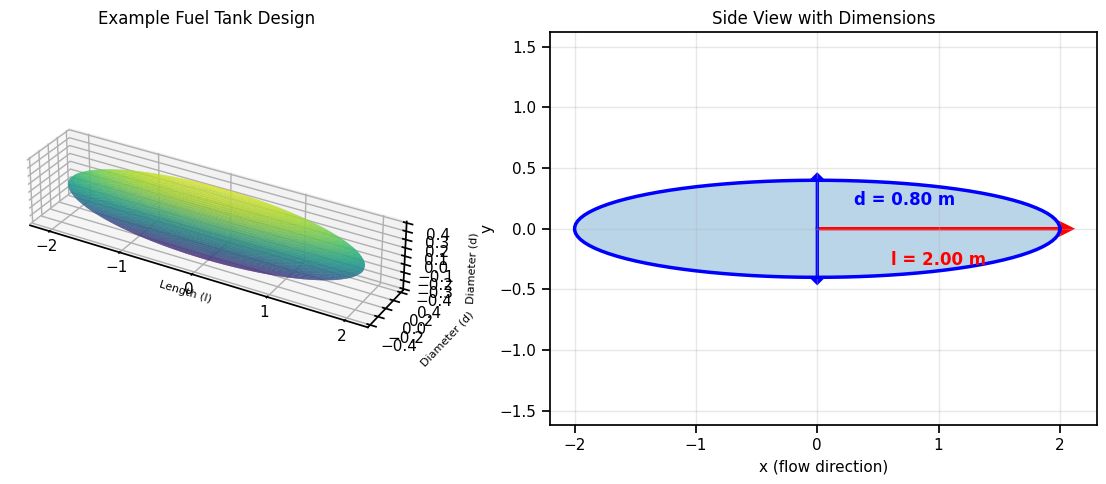


Example Design Properties:
  Length (l) = 2.00 m
  Diameter (d) = 0.80 m
  Volume = 0.6702 m³
  Aspect ratio (l/d) = 2.50


In [2]:
# Interactive visualization of ellipsoid fuel tank
from mpl_toolkits.mplot3d import Axes3D

def plot_ellipsoid(l, d, title="Ellipsoid Fuel Tank"):
    """Visualize the ellipsoid fuel tank design"""
    fig = plt.figure(figsize=(12, 5))
    
    # 3D view
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Generate ellipsoid surface
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = l * np.outer(np.cos(u), np.sin(v))
    y = d/2 * np.outer(np.sin(u), np.sin(v))
    z = d/2 * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Plot surface
    ax1.plot_surface(x, y, z, alpha=0.7, cmap='viridis', edgecolor='none')
    ax1.set_xlabel('Length (l)', fontsize=8)
    ax1.set_ylabel('Diameter (d)', fontsize=8)
    ax1.set_zlabel('Diameter (d)', fontsize=8)
    ax1.set_title(title, fontsize=12)
    ax1.set_box_aspect([l, d/2, d/2])
    
    # Side view showing dimensions
    ax2 = fig.add_subplot(122)
    theta = np.linspace(0, 2*np.pi, 100)
    x_side = l * np.cos(theta)
    y_side = d/2 * np.sin(theta)
    ax2.plot(x_side, y_side, 'b-', linewidth=2.5)
    ax2.fill(x_side, y_side, alpha=0.3)
    ax2.arrow(0, 0, l, 0, head_width=0.1, head_length=0.1, fc='red', ec='red', linewidth=2)
    ax2.text(l/2, -0.3, f'l = {l:.2f} m', fontsize=12, ha='center', color='red', fontweight='bold')
    ax2.arrow(0, 0, 0, d/2, head_width=0.1, head_length=0.05, fc='blue', ec='blue', linewidth=2)
    ax2.arrow(0, 0, 0, -d/2, head_width=0.1, head_length=0.05, fc='blue', ec='blue', linewidth=2)
    ax2.text(0.3, d/4, f'd = {d:.2f} m', fontsize=12, color='blue', fontweight='bold')
    ax2.set_xlabel('x (flow direction)', fontsize=11)
    ax2.set_ylabel('y', fontsize=11)
    ax2.set_title('Side View with Dimensions', fontsize=12)
    ax2.axis('equal')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example: visualize a candidate design
l_example = 2.0  # meters
d_example = 0.8  # meters
plot_ellipsoid(l_example, d_example, "Example Fuel Tank Design")

# Compute properties for this design
V_example = (np.pi/6) * d_example**2 * l_example
print(f"\nExample Design Properties:")
print(f"  Length (l) = {l_example:.2f} m")
print(f"  Diameter (d) = {d_example:.2f} m")
print(f"  Volume = {V_example:.4f} m³")
print(f"  Aspect ratio (l/d) = {l_example/d_example:.2f}")

### Part A: Computing Derivatives

As engineers, we need to compute the derivatives of the output objectives (drag $D$ and volume $V$) with respect to the design inputs (length $l$ and diameter $d$). Although we *could* do this analytically using calculus, we want to test the best method for computing derivatives so we can adapt when problems become more complex.

**Design Point**: Let's analyze a baseline design with $l = 2.5$ m and $d = 0.8$ m.

First, let's implement the objective functions:

In [3]:
# Constants
RHO = 0.312  # Air density at 12,000m (kg/m³)
U = 200.0    # Velocity (m/s)
C_F = 0.0035 # Skin friction coefficient

# NumPy implementations
def surface_area(l, d):
    """Ellipsoid surface area (numpy version)"""
    # Ensure l > d to avoid domain errors in arcsin
    ratio_sq = (d / l) ** 2
    if ratio_sq >= 1.0:
        # Degenerate case - return sphere surface area as approximation
        return 4 * np.pi * (d/2)**2
    sqrt_term = np.sqrt(1 - ratio_sq)
    S = (np.pi / 2) * d**2 * (1 + (l / (d * sqrt_term)) * np.arcsin(sqrt_term))
    return S

def volume(l, d):
    """Ellipsoid volume (numpy version)"""
    return (np.pi / 6) * d**2 * l

def drag_coefficient(l, d):
    """Drag coefficient for ellipsoid (numpy version)"""
    ratio = d / l
    C_D = C_F * (1 + 1.5 * ratio**(3/2) + 7 * ratio**3)
    return C_D

def drag(l, d):
    """Total drag force (numpy version)"""
    S = surface_area(l, d)
    C_D = drag_coefficient(l, d)
    D = 0.5 * RHO * U**2 * C_D * S
    return D

# Test at baseline design - use a design where l > d
l_baseline = 2.5
d_baseline = 0.8

S_baseline = surface_area(l_baseline, d_baseline)
V_baseline = volume(l_baseline, d_baseline)
CD_baseline = drag_coefficient(l_baseline, d_baseline)
D_baseline = drag(l_baseline, d_baseline)

print(f"Baseline Design (l={l_baseline}m, d={d_baseline}m):")
print(f"  Surface area: {S_baseline:.4f} m²")
print(f"  Volume: {V_baseline:.4f} m³")
print(f"  Drag coefficient: {CD_baseline:.6f}")
print(f"  Drag force: {D_baseline:.2f} N")
print(f"  Aspect ratio l/d: {l_baseline/d_baseline:.2f}")

Baseline Design (l=2.5m, d=0.8m):
  Surface area: 5.1339 m²
  Volume: 0.8378 m³
  Drag coefficient: 0.005253
  Drag force: 168.29 N
  Aspect ratio l/d: 3.12


### Understanding Backward Mode AD

Backward mode AD works by:
1. **Forward pass**: Compute all intermediate values from inputs to output
2. **Backward pass**: Starting from the output, propagate gradients backward using the chain rule

In our case we have a function with **2 inputs** ($l$, $d$) and **1 output** ($D$, drag force). Let's focus on computing the gradient of drag:

$$
\nabla D = \begin{bmatrix}
\frac{\partial D}{\partial l} \\
\frac{\partial D}{\partial d}
\end{bmatrix}
$$


For each intermediate variable $v$, we compute its **adjoint** (sensitivity):
$$
\bar{v} = \frac{\partial D}{\partial v}
$$

The adjoint tells us "how much does the output $D$ change if we perturb $v$?"

**Your Task**: Compute this gradient using **backward mode automatic differentiation** (also called reverse-mode AD or backpropagation).

### Step 1: Draw the Computational Graph

First, break down the drag computation into elementary operations. Here's a template to get you started:

```
Inputs: l, d

Intermediate calculations example (fill in the formulas):
v₁ = d/l                     (diameter-to-length ratio)
v₂ = v₁²                     
v₃ = 1 - v₂                  
v₄ = √v₃                     
v₅ = arcsin(v₄)              
v₆ = d²                      
v₇ = d·v₄                   
v₈ = l/v₇                   
v₉ = v₈·v₅                  
v₁₀ = 1 + v₉             
v₁₁ = S = π/2·v₆·v₁₀
v₁₂ = v₁³
v₁₃ = √v₁₂
v₁₄ = 1 + 1.5·v₁₃ + 7·v₁₂
v₁₅ = C_D = C_f·v₁₄
v₁₆ = D = 0.5·ρ·U²·v₁₅·v₁₁
```


**Task 1a**: Complete the computational graph by identifying ALL intermediate variables from the inputs ($l$, $d$) to the final output ($D$). Number them sequentially (v₁, v₂, v₃, ..., v_N).

**Student Response:** [Draw or write out your complete computational graph here]

### Step 2: Forward Pass

Evaluate all intermediate variables at the baseline design point: $l = 2.5$ m, $d = 0.8$ m.

**Task 1b**: Compute the numerical values of all intermediate variables in your graph.

**Student Response:** 
```
l = 2.5
d = 0.8
v₁ = d/l = 0.32
v₂ = v₁² = 0.1024                 
v₃ = 1 - v₂ = 0.8976            
v₄ = √v₃ = 0.9474175426
v₅ = arcsin(v₄) = 1.2450668395
v₆ = d² = 0.64
v₇ = d·v₄ = 0.7579340341
v₈ = l/v₇ = 3.2984400852
v₉ = v₈·v₅ = 4.1067783722
v₁₀ = 1 + v₉ = 5.1067783722
v₁₁ = π/2·v₆·v₁₀ = 5.1338935736
v₁₂ = v₁³ = 0.032768
v₁₃ = √v₁₂ = 0.181019336
v₁₄ = 1 + 1.5·v₁₃ + 7·v₁₂ = 1.4375482364
v₁₅ = C_f·v₁₄ = 0.005031418827
v₁₆ = 0.5·ρ·U²·v₁₅·v₁₁ = 161.1839971998

D = 161.1839971998
```

### Step 3: Backward Pass

Now propagate gradients backward! Start with $\bar{D} = 1$ (the gradient of $D$ with respect to itself), then work backward through the graph.

**Task 1c**: Compute all adjoints working backward from $\bar{D} = 1$ to $\bar{l}$ and $\bar{d}$.

**Student Response:**
```
Backward pass starting from D:
D̄ = 1  (seed value)
```

![back_prop](ps2_1_back_prop.png)

### Step 4: Interpretation
 ∂D/∂l = 13.513916
  ∂D/∂d = 378.488578
  ∂V/∂l = 0.335103
  ∂V/∂d = 2.094395

**Task 1d**: Once you've computed the gradients, interpret them physically:

**Question 1**: What does the value of $\frac{\partial D}{\partial l}$ imply physically? (If we increase length, does drag increase or decrease?)

**Student Response:** Drag increases with length

**Question 2**: What does the value of $\frac{\partial D}{\partial d}$ imply physically?

**Student Response:** Drag increases with width

**Question 3**: Which variable has a larger effect on drag? Does this make engineering sense?

**Student Response:** width (d) as a way bigger effect than length. this makes sense considering S has a d^2 term

### Part B: Implementing AD with PyTorch

Now let's implement automatic differentiation using PyTorch and time both the forward and backward passes.

**Your Task**: 
1. Reimplement your functions using PyTorch operations (torch tensors)
2. Compute the Jacobian matrix using PyTorch's autograd
3. Time the forward pass (function evaluation)
4. Time the backward pass (gradient computation)


In [7]:
# Student Task: Implement PyTorch versions of the functions
def surface_area_torch(l, d):
    """PyTorch version of surface_area"""
    # TODO: Implement using torch operations (torch.arcsin, torch.sqrt, etc.)
    ratio_sq = (d/l) ** 2
    if ratio_sq >= 1.0:
        return 4 * torch.pi * (d/2) ** 2
    sqrt_term = torch.sqrt(1-ratio_sq)
    S = torch.pi / 2 * d ** 2 * (1 + (l / (d * sqrt_term)) * torch.arcsin(sqrt_term))
    return S

def volume_torch(l, d):
    """PyTorch version of volume"""
    # TODO: Implement
    return (torch.pi / 6) * d ** 2 * l

def drag_coefficient_torch(l, d):
    """PyTorch version of drag_coefficient"""
    # TODO: Implement
    ratio = d / l
    C_D = C_F * (1 + 1.5 * ratio**(3/2) + 7 * ratio**3)
    return C_D

def drag_torch(l, d):
    """PyTorch version of drag"""
    # TODO: Implement
    S = surface_area_torch(l, d)
    C_D = drag_coefficient_torch(l, d)
    D = 0.5 * RHO * U**2 * C_D * S
    return D

# Compute Jacobian using PyTorch
# Hints:
# 1. Create torch tensors for l and d with requires_grad=True
# 2. Compute both outputs (D and V)
# 3. Use torch.autograd.grad or .backward() to get gradients
# 4. For a Jacobian with multiple outputs, you need to call backward() for each output

x = torch.tensor([l_baseline, d_baseline], requires_grad=True, dtype=torch.float64)
l_t, d_t = x[0], x[1]

# First row: gradients of D
D = drag_torch(l_t, d_t)
grad_D = torch.autograd.grad(D, x, retain_graph=True)[0]

# Second row: gradients of V  
V = volume_torch(l_t, d_t)
grad_V = torch.autograd.grad(V, x)[0]

jacobian = torch.stack([grad_D, grad_V]).numpy()

print("\nJacobian Matrix (from PyTorch AD):")
print(f"  ∂D/∂l = {jacobian[0,0]:.6f}")
print(f"  ∂D/∂d = {jacobian[0,1]:.6f}")
print(f"  ∂V/∂l = {jacobian[1,0]:.6f}")
print(f"  ∂V/∂d = {jacobian[1,1]:.6f}")

# Time the forward and backward passes
n_reps = 10000

# Time forward pass
start = time.time()
for _ in range(n_reps):
    x = torch.tensor([l_baseline, d_baseline], requires_grad=True, dtype=torch.float64)
    D = drag_torch(x[0], x[1])
    V = volume_torch(x[0], x[1])
time_forward = (time.time() - start) / n_reps

# Time backward pass
start = time.time()
for _ in range(n_reps):
    x = torch.tensor([l_baseline, d_baseline], requires_grad=True, dtype=torch.float64)
    D = drag_torch(x[0], x[1])
    V = volume_torch(x[0], x[1])
    grad_D = torch.autograd.grad(D, x, retain_graph=True)[0]
    grad_V = torch.autograd.grad(V, x)[0]
time_backward = (time.time() - start) / n_reps

print(f"\nTiming Results:")
print(f"  Forward pass:  {time_forward*1e6:.2f} µs")
print(f"  Backward pass: {time_backward*1e6:.2f} µs")
print(f"  Overhead of AD: {(time_backward/time_forward - 1)*100:.1f}%")


Jacobian Matrix (from PyTorch AD):
  ∂D/∂l = 13.513916
  ∂D/∂d = 378.488578
  ∂V/∂l = 0.335103
  ∂V/∂d = 2.094395

Timing Results:
  Forward pass:  63.24 µs
  Backward pass: 187.40 µs
  Overhead of AD: 196.3%


*Reflection*: Did you observe the backward pass taking more time than the forward pass? If you did, does this make sense? 
yes, because each backward pass first does a forward pass

### Part C: Constrained Optimization

Now for the real engineering problem! The aircraft requires the fuel tank to have a volume of **at least 0.5 m³** to carry enough fuel. This gives us a constraint:

$$
V \geq V_{\text{req}} = 0.5 \text{ m}^3
$$

Or equivalently (for standard optimization form):
$$
g(l, d) = V_{\text{req}} - V(l, d) \leq 0
$$

**Optimization Problem**:
$$
\begin{aligned}
\text{minimize} \quad & D(l, d) \\
\text{subject to} \quad & V(l, d) \geq 0.5 \\
& l > 0, \quad d > 0
\end{aligned}
$$

**Your Task**: Solve this optimization problem using three different methods for computing gradients:
1. **Finite differences** (from Problem 3, Part B)
2. **PyTorch automatic differentiation**
3. **Third Method: Could be the SciPy default gradient computation (SciPy defaults to a "2-point finite difference estimation with an absolute step size"), or another method, such as [complex-step method](https://mdolab.engin.umich.edu/wiki/guide-complex-step-derivative-approximation) (which can be done manually but is also built in to SciPy), another FD method, or an analytical gradient method** 

We'll use scipy's SLSQP optimizer, which is designed for constrained optimization problems. The code is provided below - your job is to implement the gradient functions and compare the results. When you compare the results, it may be useful to run multiple trials 

In [ ]:
V_REQUIRED = 0.5  # m³

# Wrapper functions for scipy (which expects 1D arrays)
def drag_wrapper(x):
    """Objective function: drag"""
    l, d = x[0], x[1]
    return drag(l, d)

def volume_constraint(x):
    """Constraint function: V - V_req >= 0"""
    l, d = x[0], x[1]
    return volume(l, d) - V_REQUIRED

# Student Task: Implement gradient functions

def drag_gradient_fd(x, eps=1e-7):
    """
    Compute gradient of drag using finite differences.
    Use the finite_difference_gradient function from Problem 3!
    """
    # TODO: Implement
    pass

def drag_gradient_torch(x):
    """
    Compute gradient of drag using PyTorch AD.
    
    Hint: Convert x to torch tensor, compute drag, call backward(), extract gradient
    """
    # TODO: Implement
    pass

def constraint_gradient_fd(x, eps=1e-7):
    """Gradient of volume constraint using finite differences"""
    # TODO: Implement
    pass

def constraint_gradient_torch(x):
    """Gradient of volume constraint using PyTorch AD"""
    # TODO: Implement
    pass

# Depending on what you do, you can also manually define the third method gradients here. 
# If you are using SciPy's built in gradient estimation methods, you do not need to define these functions.

# Initial guess (start from baseline design)
x0 = np.array([l_baseline, d_baseline])

print("="*70)
print("SOLVING CONSTRAINED OPTIMIZATION PROBLEM")
print("="*70)
print(f"Objective: Minimize drag")
print(f"Constraint: Volume >= {V_REQUIRED} m³")
print(f"Initial design: l={x0[0]:.2f}m, d={x0[1]:.2f}m")
print(f"Initial drag: {drag_wrapper(x0):.2f} N")
print(f"Initial volume: {volume(x0[0], x0[1]):.4f} m³")
print()

SOLVING CONSTRAINED OPTIMIZATION PROBLEM
Objective: Minimize drag
Constraint: Volume >= 0.5 m³
Initial design: l=2.50m, d=0.80m
Initial drag: 168.29 N
Initial volume: 0.8378 m³



**Implementation Note**: The optimization problem below may converge to different local minima depending on the initial guess. For a more robust analysis, consider running multiple trials with random initial guesses and computing both the average and best results. 

In [ ]:
# Method 1: Finite Differences
print("Method 1: Optimization with Finite Difference Gradients")
print("-"*70)
constraint_fd = {'type': 'ineq', 'fun': volume_constraint, 'jac': constraint_gradient_fd}
bounds = [(0.1, 10.0), (0.1, 10.0)]  # l and d must be positive

result_fd = optimize.minimize(
    drag_wrapper,
    x0=x0,
    method='SLSQP',
    jac=drag_gradient_fd,
    constraints=constraint_fd,
    bounds=bounds,
    options={'disp': True, 'maxiter': 100} # If you are averaging over many trials, consider turning disp off (this prints convergence information)
)

l_opt_fd, d_opt_fd = result_fd.x
print(f"\nOptimal design (FD):")
print(f"  l = {l_opt_fd:.4f} m")
print(f"  d = {d_opt_fd:.4f} m")
print(f"  Drag = {drag_wrapper(result_fd.x):.2f} N")
print(f"  Volume = {volume(l_opt_fd, d_opt_fd):.4f} m³")
print(f"  Function evaluations: {result_fd.nfev}")
print(f"  Gradient evaluations: {result_fd.njev}")
print()

In [ ]:
# Method 2: PyTorch AD
print("Method 2: Optimization with PyTorch AD Gradients")
print("-"*70)
constraint_torch = {'type': 'ineq', 'fun': volume_constraint, 'jac': constraint_gradient_torch}

result_torch = optimize.minimize(
    drag_wrapper,
    x0=x0,
    method='SLSQP',
    jac=drag_gradient_torch,
    constraints=constraint_torch,
    bounds=bounds,
    options={'disp': True, 'maxiter': 100} 
)

l_opt_torch, d_opt_torch = result_torch.x
print(f"\nOptimal design (PyTorch AD):")
print(f"  l = {l_opt_torch:.4f} m")
print(f"  d = {d_opt_torch:.4f} m")
print(f"  Drag = {drag_wrapper(result_torch.x):.2f} N")
print(f"  Volume = {volume(l_opt_torch, d_opt_torch):.4f} m³")
print(f"  Function evaluations: {result_torch.nfev}")
print(f"  Gradient evaluations: {result_torch.njev}")
print()

In [ ]:
# Method 3: Your Choice
print("Method 3: Optimization with [Third Method]")
print("-"*70)
# bogus placeholder for third method constraint
constraint_gradient_third_method = None  # Implement OR use a built in method from the SciPy documentation
constraint_third_method = {'type': 'ineq', 'fun': volume_constraint, 'jac': constraint_gradient_third_method}

result_third_method = optimize.minimize(
    drag_wrapper,
    x0=x0,
    method='SLSQP',
    jac=constraint_gradient_third_method,  # Actually implement this with your third method gradient function if applicable
    constraints=constraint_third_method,
    bounds=bounds,
    options={'disp': True, 'maxiter': 100}
)

l_opt_third_method, d_opt_third_method = result_third_method.x
print(f"\nOptimal design ([Third Method]):")
print(f"  l = {l_opt_third_method:.4f} m")
print(f"  d = {d_opt_third_method:.4f} m")
print(f"  Drag = {drag_wrapper(result_third_method.x):.2f} N")
print(f"  Volume = {volume(l_opt_third_method, d_opt_third_method):.4f} m³")
print(f"  Function evaluations: {result_third_method.nfev}")
print(f"  Gradient evaluations: {result_third_method.njev}")
print()


Average and find the best results

In [ ]:
print("="*70)
print("OPTIMIZATION RESULTS SUMMARY (BEST TRIALS)")
print("="*70)
print(f"{'Method':<20} {'l (m)':<10} {'d (m)':<10} {'Drag (N)':<12} {'Func Evals':<12} {'Grad Evals':<12}")
print("-"*70)

# bogus values:
l_opt_fd_best = -999
d_opt_fd_best = -999
nfev_fd_best = -999
njev_fd_best = -999
l_opt_torch_best = -999
d_opt_torch_best = -999
nfev_torch_best = -999
njev_torch_best = -999
l_opt_third_method_best = -999
d_opt_third_method_best = -999
nfev_third_method_best = -999
njev_third_method_best = -999

l_opt_fd_avg = -999
d_opt_fd_avg = -999
nfev_fd_avg = -999
njev_fd_avg = -999
l_opt_torch_avg = -999
d_opt_torch_avg = -999
nfev_torch_avg = -999
njev_torch_avg = -999
l_opt_third_method_avg = -999
d_opt_third_method_avg = -999
nfev_third_method_avg = -999
njev_third_method_avg = -999

print(f"{'(best) Finite Diff':<20} {l_opt_fd_best:<10.4f} {d_opt_fd_best:<10.4f} {drag_wrapper([l_opt_fd_best, d_opt_fd_best]):<12.2f} {nfev_fd_best:<12} {njev_fd_best:<12}")
print(f"{'(best) PyTorch AD':<20} {l_opt_torch_best:<10.4f} {d_opt_torch_best:<10.4f} {drag_wrapper([l_opt_torch_best, d_opt_torch_best]):<12.2f} {nfev_torch_best:<12} {njev_torch_best:<12}")
print(f"{'(best) Third Method':<20} {l_opt_third_method_best:<10.4f} {d_opt_third_method_best:<10.4f} {drag_wrapper([l_opt_third_method_best, d_opt_third_method_best]):<12.2f} {nfev_third_method_best:<12} {njev_third_method_best:<12}")
print(f"{'Average Finite Diff':<20} {l_opt_fd_avg:<10.4f} {d_opt_fd_avg:<10.4f} {drag_wrapper([l_opt_fd_avg, d_opt_fd_avg]):<12.2f} {nfev_fd_avg:<12.1f} {njev_fd_avg:<12.1f}")
print(f"{'Average PyTorch AD':<20} {l_opt_torch_avg:<10.4f} {d_opt_torch_avg:<10.4f} {drag_wrapper([l_opt_torch_avg, d_opt_torch_avg]):<12.2f} {nfev_torch_avg:<12.1f} {njev_torch_avg:<12.1f}")
print(f"{'Average [Third Method]':<20} {l_opt_third_method_avg:<10.4f} {d_opt_third_method_avg:<10.4f} {drag_wrapper([l_opt_third_method_avg, d_opt_third_method_avg]):<12.2f} {nfev_third_method_avg:<12.1f} {njev_third_method_avg:<12.1f}")

# Accuracies could be done too if you get the analytical solution:
# This can be useful, since the methods may converge to very similar results
# You can also try to exclude convergence failures from the averages above based on tolerances

# bogus values:
l_analytical = -999
d_analytical = -999

print("\nAnalytical Values (if derived - see the 'Bonus Side Note' if you are interested):")
print(f"  l = {l_analytical:.4f} m")
print(f"  d = {d_analytical:.4f} m")
print(f"  Drag = {drag_wrapper([l_analytical, d_analytical]):.2f} N")
print(f"  Volume = {volume(l_analytical, d_analytical):.4f} m³")
print("\nAnalytical Error Comparison (best):")
print(f"{'Method':<20} {'l Error (m)':<15} {'d Error (m)':<15} {'Drag Error (N)':<15}")
print("-"*70)
print(f"{'(best) Finite Diff':<20} {abs(l_opt_fd_best - l_analytical):<15.6f} {abs(d_opt_fd_best - d_analytical):<15.6f} {abs(drag_wrapper([l_opt_fd_best, d_opt_fd_best]) - drag_wrapper([l_analytical, d_analytical])):<15.6f}")
print(f"{'(best) PyTorch AD':<20} {abs(l_opt_torch_best - l_analytical):<15.6f} {abs(d_opt_torch_best - d_analytical):<15.6f} {abs(drag_wrapper([l_opt_torch_best, d_opt_torch_best]) - drag_wrapper([l_analytical, d_analytical])):<15.6f}")
print(f"{'(best) Third Method':<20} {abs(l_opt_third_method_best - l_analytical):<15.6f} {abs(d_opt_third_method_best - d_analytical):<15.6f} {abs(drag_wrapper([l_opt_third_method_best, d_opt_third_method_best]) - drag_wrapper([l_analytical, d_analytical])):<15.6f}")
print(f"{'Average Finite Diff':<20} {abs(l_opt_fd_avg - l_analytical):<15.6f} {abs(d_opt_fd_avg - d_analytical):<15.6f} {abs(drag_wrapper([l_opt_fd_avg, d_opt_fd_avg]) - drag_wrapper([l_analytical, d_analytical])):<15.6f}")
print(f"{'Average PyTorch AD':<20} {abs(l_opt_torch_avg - l_analytical):<15.6f} {abs(d_opt_torch_avg - d_analytical):<15.6f} {abs(drag_wrapper([l_opt_torch_avg, d_opt_torch_avg]) - drag_wrapper([l_analytical, d_analytical])):<15.6f}")
print(f"{'Average [Third Method]':<20} {abs(l_opt_third_method_avg - l_analytical):<15.6f} {abs(d_opt_third_method_avg - d_analytical):<15.6f} {abs(drag_wrapper([l_opt_third_method_avg, d_opt_third_method_avg]) - drag_wrapper([l_analytical, d_analytical])):<15.6f}")


OPTIMIZATION RESULTS SUMMARY (BEST TRIALS)
Method               l (m)      d (m)      Drag (N)     Func Evals   Grad Evals  
----------------------------------------------------------------------
(best) Finite Diff   -999.0000  -999.0000  650514660.30 -999         -999        
(best) PyTorch AD    -999.0000  -999.0000  650514660.30 -999         -999        
(best) Third Method  -999.0000  -999.0000  650514660.30 -999         -999        
Average Finite Diff  -999.0000  -999.0000  650514660.30 -999.0       -999.0      
Average PyTorch AD   -999.0000  -999.0000  650514660.30 -999.0       -999.0      
Average Third Method -999.0000  -999.0000  650514660.30 -999.0       -999.0      

Analytical Values (if derived - see the 'Bonus Side Note' if you are interested):
  l = -999.0000 m
  d = -999.0000 m
  Drag = 650514660.30 N
  Volume = -522029549.5442 m³

Analytical Error Comparison (best):
Method               l Error (m)     d Error (m)     Drag Error (N) 
---------------------------------

2.5 0.8 -999 -999 -999 -999


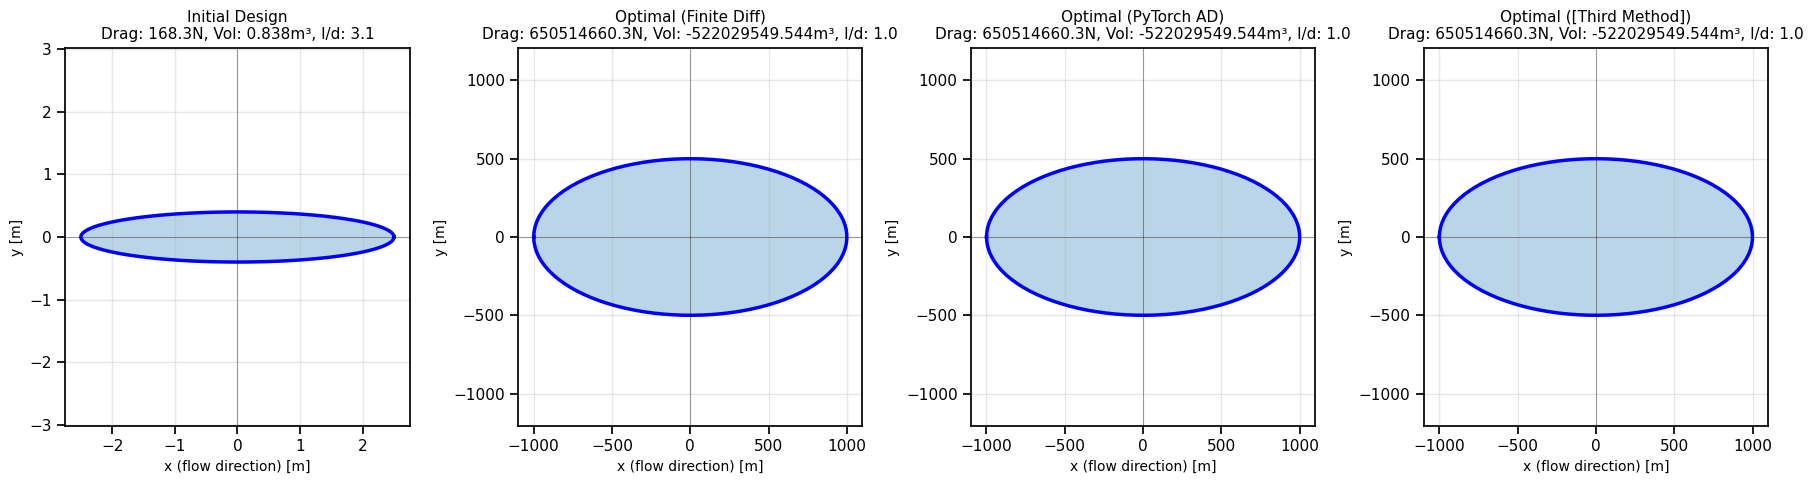

Initial aspect ratio: 3.1:1
Optimal aspect ratio: 1.0:1
Drag reduction: -386548751.7%


In [ ]:
# Visualize initial and optimal designs
fig, axes = plt.subplots(1, 4, figsize=(18, 5))


designs = [
    (l_baseline, d_baseline, "Initial Design"),
    (l_opt_fd_best, d_opt_fd_best, "Optimal (Finite Diff)"),
    (l_opt_torch_best, d_opt_torch_best, "Optimal (PyTorch AD)"),
    (l_opt_third_method_best, d_opt_third_method_best, "Optimal ([Third Method])")
]

print(l_baseline, d_baseline, l_opt_fd_best, d_opt_fd_best, l_opt_torch_best, d_opt_torch_best)

for idx, (l, d, title) in enumerate(designs):
    ax = axes[idx]
    theta = np.linspace(0, 2*np.pi, 100)
    x_side = l * np.cos(theta)
    y_side = d/2 * np.sin(theta)
    ax.plot(x_side, y_side, 'b-', linewidth=2.5)
    ax.fill(x_side, y_side, alpha=0.3)
    ax.set_xlabel('x (flow direction) [m]', fontsize=10)
    ax.set_ylabel('y [m]', fontsize=10)
    drag_val = drag(l, d)
    vol_val = volume(l, d)
    ax.set_title(f'{title}\nDrag: {drag_val:.1f}N, Vol: {vol_val:.3f}m³, l/d: {l/d:.1f}', fontsize=11)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    # Add aspect markers
    ax.axhline(0, color='k', linewidth=0.5, alpha=0.5)
    ax.axvline(0, color='k', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Initial aspect ratio: {x0[0]/x0[1]:.1f}:1")
print(f"Optimal aspect ratio: {l_opt_torch_best/d_opt_torch_best:.1f}:1")
print(f"Drag reduction: {(1 - drag(l_opt_torch_best, d_opt_torch_best)/drag(x0[0], x0[1]))*100:.1f}%")

### Bonus Side Note:
As a smart engineer, you may have realized that the volume constraint is probably active at the optimum (i.e., the tank will just meet the volume requirement). With this information, you can reduce the problem to a single-variable optimization by expressing one variable in terms of the other using the volume constraint, allowing you to solve this analytically without the need for constrained optimization methods.

If you want, you can easily derive this, and compare your solution against the analytical one - this could help you compare the numerical accuracy of your optimization results in a more rigorous way.

## Problem 3: Bouncing Ball Sensitivity Analysis

### Background

One powerful application of automatic differentiation is **sensitivity analysis**: understanding how outputs depend on inputs.

AD makes sensitivity analysis trivial—we just compute gradients! Without AD, you'd need finite differences (slow and inaccurate) or hand-derived formulas (error-prone and not maintainable).

### The Problem

Consider a simple physics simulation: a bouncing ball. The simulation has parameters:
- `g`: gravitational acceleration (m/s²)
- `e`: coefficient of restitution - controls energy loss (0 < e < 1)
- `v0`: initial velocity (m/s)
- `h0`: initial height (m)

We will use the following parameters:
g = 10.0 m/s²
e = 0.9
v0 = 0.0 m/s
h0 = 10.0 m

And we will use a dt of 0.01 seconds for the simulation time step, for a total of 1000 time steps.

The simulation uses a simple Euler integrator with a conditional (bounce detection), making it non-trivial to differentiate by hand!

Final velocity: -5.48 m/s
Final height: 3.41 m

Parameters: g=10.0, e=0.9, v0=0.0, h0=10.0


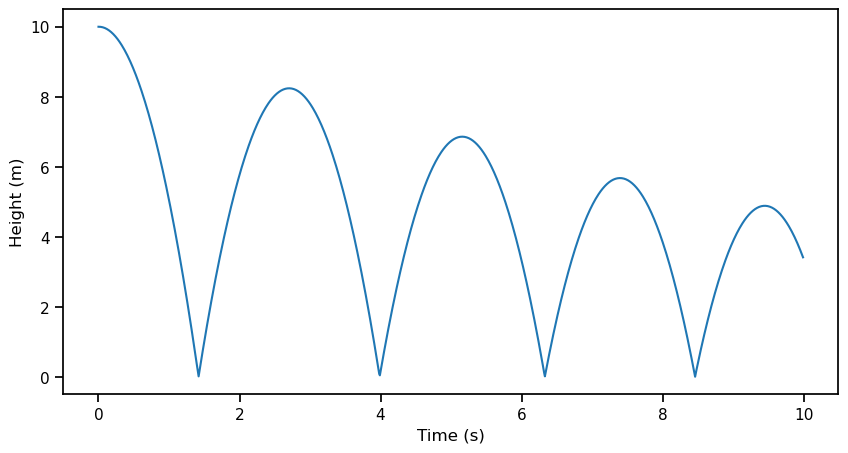

In [ ]:

def bounce_simulation(g, e, v0, h0, num_timesteps=1000):
    """
    Simulate a bouncing ball using Euler integration.
    
    Args:
        g: gravity
        e: coefficient of restitution
        v0: initial velocity
        h0: initial height
        num_timesteps: number of timesteps to simulate
    Returns:
        v_final: final velocity after simulation
    """
    v = 0
    h = 0
    hprev = h0
    vprev = v0
    dt = 0.01 # seconds
    h_tape = [hprev]
    t_tape = [0]
    v_tape = [vprev]
    
    for i in range(1, num_timesteps):
        # # Update position and velocity
        h = hprev + vprev * dt
        v = vprev - g * dt
        
        # Check for bounce (conditional!)
        if h <= 0:  
            h = -h  # Assume ball regains height lost
            v = -e * v  # Reverse velocity with energy loss
        
        hprev = h
        vprev = v
        t_tape.append(t_tape[-1] + dt)
        h_tape.append(h)
        v_tape.append(v)

    return v, h, h_tape, t_tape, v_tape

# Side note: Since we are using Euler/verlet integration - 
# if you change h0 or another parameter to get a lot of bounces, the error may accumulate significantly.
# This could result in an unphysical result (e.g., the ball bouncing higher than its initial height).
# For our purposes here, dt and timesteps have been tuned for the parameters you will try to keep this error small.
g = 10.0
e = 0.9
v0 = 0.0
h0 = 10.0
# Test the simulation
v_final, h_final, h_tape, t_tape, v_tape = bounce_simulation(g, e, v0, h0, 1000)
print(f"Final velocity: {v_final:.2f} m/s")
print(f"Final height: {h_final:.2f} m")
print(f"\nParameters: g={g}, e={e}, v0={v0}, h0={h0}")
plt.figure(figsize=(10, 5))
plt.plot(t_tape, h_tape, label='Height (m)')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
v_tape_h0_1 = v_tape
h_tape_h0_1 = h_tape


### Part A: Sensitivity Analysis

**Question**: Which parameter has the biggest influence on the final velocity?

With AD, we want to compute the sensitivities:
$$
\nabla v_{\text{final}} = \left[\frac{\partial v_{\text{final}}}{\partial g}, \frac{\partial v_{\text{final}}}{\partial e}, \frac{\partial v_{\text{final}}}{\partial v_0}, \frac{\partial v_{\text{final}}}{\partial h_0}\right]
$$

**Your Task**: Use PyTorch to compute these sensitivities at the final timestep. Also, plot your sensitivities as a function of time. You may want to change the function such that the input is a vector of parameters rather than separate scalars.

In [ ]:
# Compute gradient using PyTorch
# Hint: Call backward() on the final velocity with respect to inputs within a loop over the timesteps

pass  # TODO: Implement your PyTorch AD sensitivity analysis here

**Question 1**: Which parameter has the largest influence on the final velocity (largest absolute sensitivity)?

**Student Response:** [Insert your answer here]

**Question 2**: How do the sensitivities behave as a function of time? What happens to each parameter at and between bounces?

**Student Response:** [Insert your answer here]

**Question 3**: What happens when we change $h_0$ to 1.0 m? How do the sensitivities change?

**Student Response:** [Insert your answer here]

**Question 4**: What parameters have the least influence on the final velocity? Is there a flaw in the simulation or AD approach that could explain this - or does everything make sense physically?

**Student Response:** [Insert your answer here]

### Part B: Diagnosing the Results

**Observation**: You may have noticed that the sensitivity to one of the parameters is approximately zero. Let's investigate this further.

We can confirm our suspicions by double-checking our AD result against an approximate sensitivity calculation.

**Task**: For the parameter(s) you found to have near-zero sensitivity, compute a sensitivity approximation by perturbing the parameter in question. Plot the sensitvity as a function of time and compare it to the AD result. 

In [ ]:
# Plot the sensitivity results

pass  # TODO: Implement your sensitivity plotting code here

**Question 1**: Is there a discrepancy between the AD and approximated results? If so, why could this be happening? (Hint: are there discontinuities in the simulation or not?)

**Student Response:** [Insert your answer here]

**Question 2**: If there is a discrepancy, how would you fix it? If not, why does everything make sense physically? (You do not actually need to implement the fix, just describe it. Alternatively, you can try and prove that no discrepancy exists (i.e by writing out an example AD computation through a bounce))

**Student Response:** [Insert your answer here]